In [30]:
#Importing the dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
#This is the code for converting the ubyte file to the csv files 
def convert(img,label,outfile,n):
  imgf =open(img,"rb")
  labelf=open(label,"rb")
  csvf=open(outfile,"w")
  imgf.read(16)
  labelf.read(8)
  images=[]
  for i in range(n):
    image=[ord(labelf.read(1))]
    for j in range(28*28):
      image.append(ord(imgf.read(1)))
    images.append(image)
  for image in images:
    csvf.write(",".join(str(pix) for pix in image)+"\n")
  imgf.close()
  csvf.close()
  labelf.close()

In [6]:
#loading the data from the directory
trainx=r'C:\Users\soham\OneDrive\Documents\ALL TASK OF FACIAL LANDMARK PROJECT\task_1_neutralN_from _scratch\archive (2)\train-images.idx3-ubyte'
trainy=r'C:\Users\soham\OneDrive\Documents\ALL TASK OF FACIAL LANDMARK PROJECT\task_1_neutralN_from _scratch\archive (2)\train-labels.idx1-ubyte'
testy=r'C:\Users\soham\OneDrive\Documents\ALL TASK OF FACIAL LANDMARK PROJECT\task_1_neutralN_from _scratch\archive (2)\t10k-labels.idx1-ubyte'
testx=r'C:\Users\soham\OneDrive\Documents\ALL TASK OF FACIAL LANDMARK PROJECT\task_1_neutralN_from _scratch\archive (2)\t10k-images.idx3-ubyte'

In [5]:
#calling the covert function
convert(trainx,trainy,r'C:\Users\soham\OneDrive\Documents\ALL TASK OF FACIAL LANDMARK PROJECT\task_1_neutralN_from _scratch\archive (2)\train.csv',60000)
convert(testx,testy,r'C:\Users\soham\OneDrive\Documents\ALL TASK OF FACIAL LANDMARK PROJECT\task_1_neutralN_from _scratch\archive (2)\test.csv',10000)

In [7]:
#This code sets up the data for a neural network by reading the CSV files, shuffling, splitting into training and validation sets, normalizing the data,
#and preparing the feature matrices Xtrain, Xdev and label vectors Ytrain, Ydev.
trainset=pd.read_csv(r'C:\Users\soham\OneDrive\Documents\ALL TASK OF FACIAL LANDMARK PROJECT\task_1_neutralN_from _scratch\archive (2)\train.csv')
testset=pd.read_csv(r'C:\Users\soham\OneDrive\Documents\ALL TASK OF FACIAL LANDMARK PROJECT\task_1_neutralN_from _scratch\archive (2)\test.csv')
trainset=np.array(trainset)
m,n=trainset.shape
np.random.shuffle(trainset)
datadev=trainset[0:1000].T
Ydev=datadev[0]
Xdev=datadev[1:n]
Xdev=Xdev / 255.
datatrain=trainset[1000:m].T
Ytrain=datatrain[0]
Xtrain=datatrain[1:n]
Xtrain=Xtrain / 255.
_,m_train=Xtrain.shape

In [9]:
def one_hot(Y):
    # Create a matrix of zeros with shape (number of examples, number of unique classes)
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    # Set the appropriate index in each row to 1, based on the class label
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [10]:
trainydata=one_hot(Ytrain)

In [11]:
#initializing the parameter for the model like layers,weights, biases
def initializepara(layer):
  parameter={}
  l=len(layer)
  for i in range(1,l):
    parameter["W"+str(i)]=np.random.randn(layer[i],layer[i-1])*0.01
    parameter["b"+str(i)]=np.zeros((layer[i],1))
  return parameter

In [12]:
#Defining the sigmoid function
def sigmoid(Z):
  A=1/(1+np.exp(-Z))
  cache=Z
  return A,cache

In [13]:
#Defining the relu function
def relu(Z):
  A=np.maximum(0,Z)
  cache=Z
  return A,cache

In [14]:
#Defining the softmax function
def softmax(Z):
  A=np.exp(Z)/np.sum(np.exp(Z),axis=0,keepdims=True)
  cache=Z
  return A,cache

In [15]:
#Implements the linear part of forward propagation for a single layer.

def linearforward(A,W,b):
  z=np.dot(W,A)+b
  cache=(A,W,b)
  return z,cache

In [16]:
#This function abstracts the choice of activation function for the layer, enabling the network to handle different activation types efficiently.
def forwardactivation(Aprev,W,b,activation):
  if activation=="sigmoid":
    Z,lincache=linearforward(Aprev,W,b)
    A,actcache=sigmoid(Z)
  elif activation=="relu":
    Z,lincache=linearforward(Aprev,W,b)
    A,actcache=relu(Z)
  elif activation=="softmax":
    Z,lincache=linearforward(Aprev,W,b)
    A,actcache=softmax(Z)
  cache=(lincache,actcache)
  return A,cache

In [17]:
#Implements forward propagation for the entire network.

def forwardprop(X,parameters):
  caches=[]  # List to store caches for each layer
  A=X    # Set the input data as the activation of the 0th layer
  l=len(parameters)//2  #Number of layers (each layer has W and b)
  for i in range(1,l):
    Aprev=A
    A,cache=forwardactivation(Aprev,parameters["W"+str(i)],parameters["b"+str(i)],"relu")
    caches.append(cache)
  # Compute the output of the final layer using softmax activation  
  AL,cache=forwardactivation(A,parameters["W"+str(l)],parameters["b"+str(l)],"softmax")
  caches.append(cache)
  return AL,caches

In [18]:
#The costcompute function calculates the cross-entropy cost for a neural network
def costcompute(AL,Y):
  m=Y.shape[1]
  cost=-np.sum(Y*np.log(AL))/m
  cost=np.squeeze(cost)
  return cost

In [19]:
#Implements the linear portion of backward propagation for a single layer.
#computing the gradient of the cost function with respect to the weight ,biases,input.
def linearbackward(dZ,cache):
  Aprev,W,b=cache
  m=Aprev.shape[1]
  dW=np.dot(dZ,Aprev.T)/m
  db=np.sum(dZ, axis=1, keepdims=True) / m
  dAprev=np.dot(W.T,dZ)
  return dAprev,dW,db

In [20]:
#Defining the reludrivative function
def Reluderiv(Z):
    return Z > 0

In [21]:
#Implements the backward propagation for the entire network.
def backwardprop(AL,Y,caches):
  grads={}
  l=len(caches)
  m=AL.shape[1]
  Y=Y.reshape(AL.shape)
  # Compute the gradient of the cost with respect to AL (softmax output)
  dAL=AL-Y

  # Backpropagation for the last layer (softmax + linear)
  currentcache=caches[-1]
  grads["dA"+str(l)],grads["dW"+str(l)],grads["db"+str(l)]=linearbackward(dAL,currentcache[0])
  # Loop over all hidden layers in reverse order, using ReLU derivative
  for i in reversed(range(l-1)):
    currentcache=caches[i]
    dAprev,dW,db=linearbackward(grads["dA"+str(i+2)]*Reluderiv(currentcache[1]),currentcache[0])
    grads["dA"+str(i+1)]=dAprev
    grads["dW"+str(i+1)]=dW
    grads["db"+str(i+1)]=db
  return grads

In [22]:
#Initializes the velocity terms for gradient descent with momentum optimization algo.
def initializevelocity(parameters):
  l=len(parameters)//2
  v={}
  for i in range(1,l+1):
    v["dw"+str(i)]=np.zeros(parameters["W"+str(i)].shape)
    v["db"+str(i)]=np.zeros(parameters["b"+str(i)].shape)
  return v

In [23]:
#Function for implementing gradient descent with momentum algo 
def upadatewithmomentum(parameters,grads,v,beta,learningrate):
  l=len(parameters)//2
  for i in range(1,l+1):
    v["dw"+str(i)]=beta*v["dw"+str(i)]+(1-beta)*grads["dW"+str(i)]
    v["db" +str(i)]=beta*v["db"+str(i)]+(1-beta)*grads["db"+str(i)]
    parameters["W"+str(i)]=parameters["W"+str(i)]-learningrate*v["dw"+str(i)]
    parameters["b"+str(i)]=parameters["b"+str(i)]-learningrate*v["db"+str(i)]
  return parameters,v

In [24]:
#Defining the function for updating the parameters
def updateparameters(parameters,grads,learningrate):
  l=len(parameters)//2
  for i in range(1,l+1):
    parameters["W"+str(i)]=parameters["W"+str(i)]-learningrate*grads["dW"+str(i)]
    parameters["b"+str(i)]=parameters["b"+str(i)]-learningrate*grads["db"+str(i)]
  return parameters

In [25]:
def get_predictions(A2):
    #Uses np.argmax to find the index of the maximum value
    #Returns an array of predicted class labels
    return np.argmax(A2, 0)
#defining the funtion for the accuracy calculations
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [26]:
def llayermodel(X, Y, layer, learningrate=0.0075, numiterations=3000, printcost=False):
  costs=[]
  parameters=initializepara(layer)
  for i in range(numiterations):
    # Forward propagation
    AL,caches=forwardprop(X,parameters)
    # Compute cost
    cost=costcompute(AL,Y)
    # Backward propagation
    grads=backwardprop(AL,Y,caches)
    # Update parameters
    parameters=updateparameters(parameters,grads,learningrate)
    # Print cost every 100 iterations if specified
    if printcost and i%100==0:
      print("cost after iteration %i: %f" %(i,cost))
    if printcost and i%100==0:
     costs.append(cost)
  #plot the cost over iterations   
  plt.plot(np.squeeze(costs))
  plt.ylabel("cost")
  plt.xlabel("iterations ")
  plt.title("learning rate:"+str(learningrate))
  plt.show()
  return parameters

cost after iteration 0: 2.302564
cost after iteration 100: 1.730054
cost after iteration 200: 0.738730
cost after iteration 300: 0.532786
cost after iteration 400: 0.443739
cost after iteration 500: 0.394467
cost after iteration 600: 0.366918
cost after iteration 700: 0.349469
cost after iteration 800: 0.337054
cost after iteration 900: 0.327481
cost after iteration 1000: 0.319671
cost after iteration 1100: 0.313008
cost after iteration 1200: 0.307187
cost after iteration 1300: 0.301939
cost after iteration 1400: 0.297127
cost after iteration 1500: 0.292754
cost after iteration 1600: 0.288818
cost after iteration 1700: 0.285166
cost after iteration 1800: 0.281755
cost after iteration 1900: 0.278538
cost after iteration 2000: 0.275503
cost after iteration 2100: 0.272601
cost after iteration 2200: 0.269805
cost after iteration 2300: 0.267138
cost after iteration 2400: 0.264623
cost after iteration 2500: 0.262267
cost after iteration 2600: 0.260022
cost after iteration 2700: 0.257853
cost

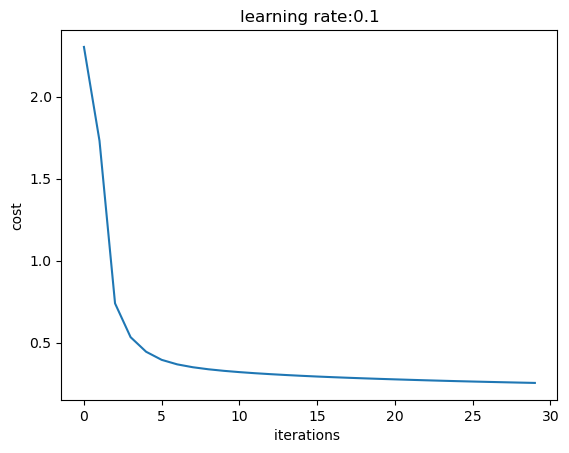

In [27]:
parameters=llayermodel(Xtrain,trainydata,[784,10,10],0.1,3000,True)

In [31]:
AL,cache=forwardprop(Xtrain,parameters)
t=get_accuracy(get_predictions(AL),Ytrain)
print("Accuracy: " + str(t*100)+"%")

[2 1 3 ... 2 8 0] [2 1 3 ... 2 5 0]
Accuracy: 92.89818471499517%
